# **Exploración de Datos**
## Nombre: Jorge Eliecer Rojas Gomez
## Asesora: Daniela Serna
## Proyecto: Modelo Analítico Pago De Cartera
## Universidad de Antioquia

# Librerias

In [ ]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#SQL Context
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import *
sqlCtx = SQLContext(sc)

from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.ml.feature import VectorAssembler

# Cargue de datos

In [ ]:
df_DataSet1 = pd.read_csv('Colocaciones_de_Cr_dito_Sector_Agropecuario_-_2021.csv',sep=',')
df_DataSet1.head()

df_InicialSinCambios = df_DataSet1.copy()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_DataSet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Año                                    479978 non-null  object 
 1   Mes                                    479978 non-null  int64  
 2   fuente Colocacion                      479978 non-null  object 
 3   Id Tipo Prod                           479978 non-null  int64  
 4   Tipo Productor                         479978 non-null  object 
 5   Valor Inversion                        479978 non-null  object 
 6   Colocacion                             479978 non-null  object 
 7   ID Depto                               479978 non-null  int64  
 8   Departamento Inversion                 479978 non-null  object 
 9   Id Munic                               479978 non-null  object 
 10  Municipio Inversion                    479978 non-null  

In [ ]:
df_DataSetInicial = df_DataSet1.copy() # se realiza una copia del dataset para tener de respaldo
df_DataSet1.head()


,Año,Mes,fuente Colocacion,Id Tipo Prod,Tipo Productor,Valor Inversion,Colocacion,ID Depto,Departamento Inversion,Id Munic,...,Linea de Credito,Linea de Produccion,ID Rubro,Destino de Credito,Genero,% FAG,Vlr Inic Garantia,LATITUD,LONGITUD,CANTIDAD
0,"2,021",2,REDESCUENTO,1,MEDIANO,"25,000,000","11,185,899",15,BOYACÁ,"15,599",...,Normalización de Cartera,SIEMBRAS (I),"141,550",141550 TOMATE DE ÁRBOL - PERENNES - SIEMBRA,M,NaN,NaN,5.416667,-73.333333,1
1,"2,021",2,REDESCUENTO,1,MEDIANO,"53,600,000","40,000,000",19,CAUCA,"19,548",...,Inversión,INFRAEST Y ADECU DE TIERRAS (I),"347,050",347050 Construcción beneficiaderos de café,H,NaN,NaN,2.750000,-76.500000,1
2,"2,021",2,REDESCUENTO,1,MEDIANO,"107,759,000","100,000,000",5,ANTIOQUIA,"5,237",...,Inversión,INFRAEST Y ADECU DE TIERRAS (I),"347,495",347495 Reparación infraestructura pecuaria,H,NaN,NaN,6.500000,-75.333333,1
3,"2,021",2,AGROPECUARIA,0,PEQUEÑO,"2,950,000","2,089,560",76,VALLE DEL CAUCA,"76,233",...,Normalización de Cartera,SOSTENIMIENTO (CT),"160,000",160000 CAPITAL DE TRABAJO - UNIDAD PRODUCTIVA ...,M,NaN,NaN,3.660278,-76.692778,1
4,"2,021",2,AGROPECUARIA,0,PEQUEÑO,"7,700,000","6,801,690",13,BOLÍVAR,"13,670",...,Normalización de Cartera,MAQUINARIA Y EQUIPO (I),"447,350",447350 Equipos para acuicultura y pesca,H,NaN,NaN,10.052778,-75.268056,1


In [ ]:
df_DataSet1.describe()

,Mes,Id Tipo Prod,ID Depto,DEPCOL,Plazo,% FAG,LATITUD,LONGITUD,CANTIDAD
count,479978.000000,479978.000000,479978.000000,479978.00000,479978.000000,301147.000000,479978.000000,479978.000000,479978.0
mean,6.697232,0.167533,38.750620,38.15367,44.873746,80.716188,5.089111,-74.905629,1.0
std,3.380452,0.434091,25.422284,25.46692,31.929417,10.210081,2.475267,1.557761,0.0
min,1.000000,0.000000,5.000000,5.00000,1.000000,1.000000,-4.215278,-81.750000,1.0
25%,4.000000,0.000000,17.000000,15.00000,18.000000,80.000000,3.166667,-76.000000,1.0
50%,7.000000,0.000000,25.000000,25.00000,36.000000,80.000000,5.200000,-75.083333,1.0
75%,10.000000,0.000000,66.000000,63.00000,60.000000,80.000000,6.464167,-73.612778,1.0
max,12.000000,2.000000,99.000000,99.00000,240.000000,100.000000,12.576855,-67.046459,1.0


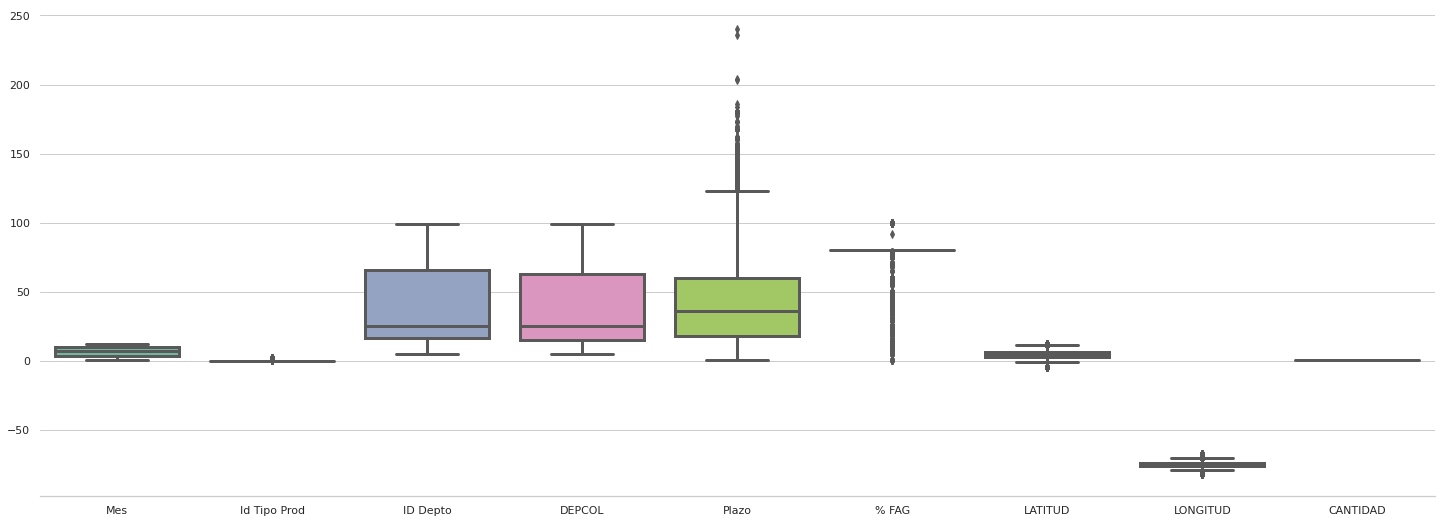

In [ ]:
import seaborn as sns # Librería de visualización para data science

sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = df_DataSet1, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con escalamiento estándar
sns.despine(left=True)

# Validación Dato de interes

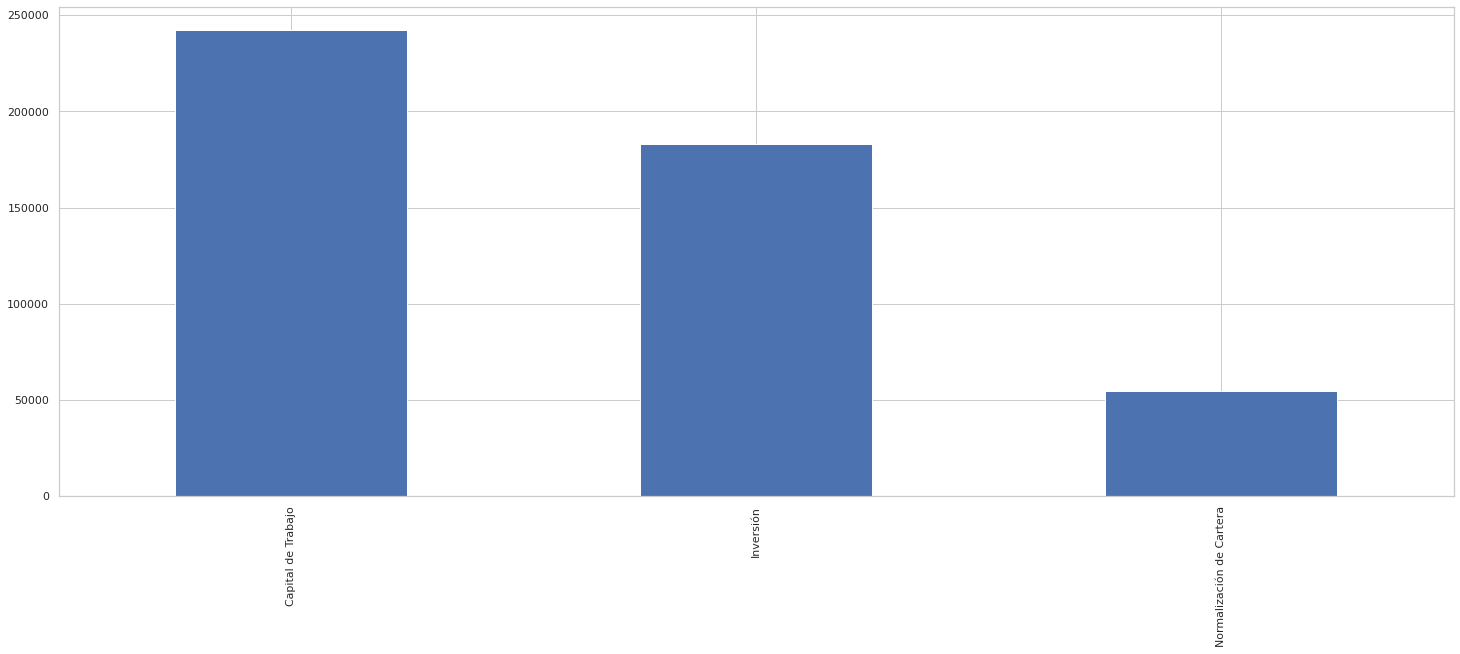

In [ ]:
# Visualizar el dato de interes Linea de Credito
pd.value_counts(df_DataSet1["Linea de Credito"]).plot(kind="bar")

In [ ]:
print(df_DataSet1.groupby('Linea de Credito').size()) # df_DataSet1["Linea de Credito"]

Linea de Credito
Capital de Trabajo          242165
Inversión                   183125
Normalización de Cartera     54688
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


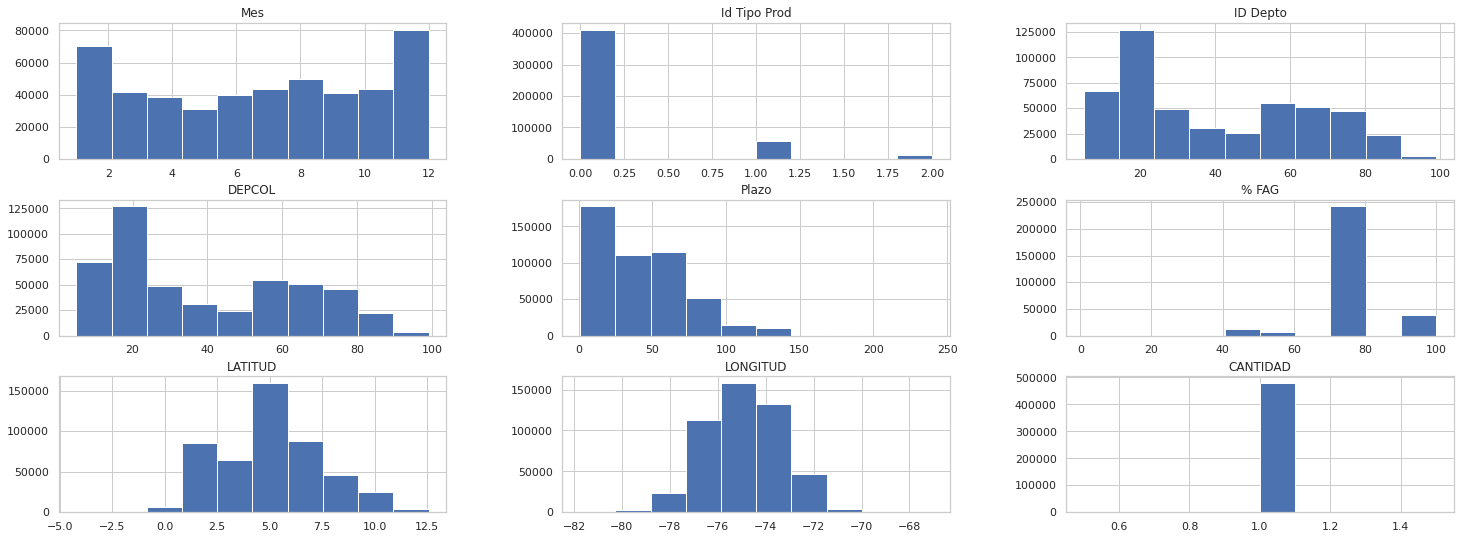

In [ ]:
df_DataSet1.drop(['Linea de Credito'],1).hist()
plt.show()


# Tratamiento de variables y limpieza

In [ ]:
df_DataSet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Año                                    479978 non-null  object 
 1   Mes                                    479978 non-null  int64  
 2   fuente Colocacion                      479978 non-null  object 
 3   Id Tipo Prod                           479978 non-null  int64  
 4   Tipo Productor                         479978 non-null  object 
 5   Valor Inversion                        479978 non-null  object 
 6   Colocacion                             479978 non-null  object 
 7   ID Depto                               479978 non-null  int64  
 8   Departamento Inversion                 479978 non-null  object 
 9   Id Munic                               479978 non-null  object 
 10  Municipio Inversion                    479978 non-null  

In [ ]:
# Convertir variables tipo object en Categoricas

df_DataSet1['Año']=df_DataSet1['Año'].astype('category')
df_DataSet1['fuente Colocacion']=df_DataSet1['fuente Colocacion'].astype('category')
df_DataSet1['Tipo Productor']=df_DataSet1['Tipo Productor'].astype('category')
df_DataSet1['Departamento Inversion']=df_DataSet1['Departamento Inversion'].astype('category')
df_DataSet1['Municipio Inversion']=df_DataSet1['Municipio Inversion'].astype('category')
df_DataSet1['Municipio de PostConflico?']=df_DataSet1['Municipio de PostConflico?'].astype('category')
df_DataSet1['Departamento de Colocacion de Credito']=df_DataSet1['Departamento de Colocacion de Credito'].astype('category')
df_DataSet1['Municipio Colocacion de Credito']=df_DataSet1['Municipio Colocacion de Credito'].astype('category')
df_DataSet1['Linea de Credito']=df_DataSet1['Linea de Credito'].astype('category')
df_DataSet1['Linea de Produccion']=df_DataSet1['Linea de Produccion'].astype('category')
df_DataSet1['Destino de Credito']=df_DataSet1['Municipio Colocacion de Credito'].astype('category')
df_DataSet1['Genero']=df_DataSet1['Genero'].astype('category')
df_DataSet1['ID Rubro']=df_DataSet1['ID Rubro'].astype('string')
df_DataSet1['MUNCOL']=df_DataSet1['MUNCOL'].astype('category')
df_DataSet1['Id Munic']=df_DataSet1['Id Munic'].astype('category')
df_DataSet1['Valor Inversion']=df_DataSet1['Valor Inversion'].astype('string')
df_DataSet1['Colocacion']=df_DataSet1['Colocacion'].astype('string').replace(',','.')#.astype(float)
df_DataSet1['Vlr Inic Garantia']=df_DataSet1['Vlr Inic Garantia'].astype('category') #.astype('string').replace(',','.')#.astype(float)

df_DataSet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   Año                                    479978 non-null  category
 1   Mes                                    479978 non-null  int64   
 2   fuente Colocacion                      479978 non-null  category
 3   Id Tipo Prod                           479978 non-null  int64   
 4   Tipo Productor                         479978 non-null  category
 5   Valor Inversion                        479978 non-null  string  
 6   Colocacion                             479978 non-null  string  
 7   ID Depto                               479978 non-null  int64   
 8   Departamento Inversion                 479978 non-null  category
 9   Id Munic                               479978 non-null  category
 10  Municipio Inversion                    47997

In [ ]:
# Se realiza la conversion de variables a tipos numericos

df_DataSet1['Colocacion'] = df_DataSet1['Colocacion'].apply(lambda x: x.replace(',',''))
df_DataSet1['Colocacion']=df_DataSet1['Colocacion'].astype(float)

df_DataSet1['Valor Inversion'] = df_DataSet1['Valor Inversion'].apply(lambda x: x.replace(',',''))
df_DataSet1['Valor Inversion']=df_DataSet1['Valor Inversion'].astype(float)

df_DataSet1['Id Munic'] = df_DataSet1['Id Munic'].apply(lambda x: x.replace(',',''))
df_DataSet1['Id Munic']=df_DataSet1['Id Munic'].astype(int)

df_DataSet1['MUNCOL'] = df_DataSet1['MUNCOL'].apply(lambda x: x.replace(',',''))
df_DataSet1['MUNCOL']=df_DataSet1['MUNCOL'].astype(int)

df_DataSet1['ID Rubro'] = df_DataSet1['ID Rubro'].apply(lambda x: x.replace(',',''))
df_DataSet1['ID Rubro']=df_DataSet1['ID Rubro'].astype(float)

In [ ]:
df_DataSet1.head()

,Año,Mes,fuente Colocacion,Id Tipo Prod,Tipo Productor,Valor Inversion,Colocacion,ID Depto,Departamento Inversion,Id Munic,...,Linea de Credito,Linea de Produccion,ID Rubro,Destino de Credito,Genero,% FAG,Vlr Inic Garantia,LATITUD,LONGITUD,CANTIDAD
0,"2,021",2,REDESCUENTO,1,MEDIANO,25000000.0,11185899.0,15,BOYACÁ,15599,...,Normalización de Cartera,SIEMBRAS (I),141550.0,RAMIRIQUÍ,M,NaN,NaN,5.416667,-73.333333,1
1,"2,021",2,REDESCUENTO,1,MEDIANO,53600000.0,40000000.0,19,CAUCA,19548,...,Inversión,INFRAEST Y ADECU DE TIERRAS (I),347050.0,PIENDAMÓ - TUNÍA,H,NaN,NaN,2.750000,-76.500000,1
2,"2,021",2,REDESCUENTO,1,MEDIANO,107759000.0,100000000.0,5,ANTIOQUIA,5237,...,Inversión,INFRAEST Y ADECU DE TIERRAS (I),347495.0,DONMATÍAS,H,NaN,NaN,6.500000,-75.333333,1
3,"2,021",2,AGROPECUARIA,0,PEQUEÑO,2950000.0,2089560.0,76,VALLE DEL CAUCA,76233,...,Normalización de Cartera,SOSTENIMIENTO (CT),160000.0,CALI,M,NaN,NaN,3.660278,-76.692778,1
4,"2,021",2,AGROPECUARIA,0,PEQUEÑO,7700000.0,6801690.0,13,BOLÍVAR,13670,...,Normalización de Cartera,MAQUINARIA Y EQUIPO (I),447350.0,SAN PABLO,H,NaN,NaN,10.052778,-75.268056,1


Se realiza la limpieza de datos que no son de intereses y no aportan en el proceso.

* La variable Año corresponde a un valor unico 2021 para todos los registros
* La variable Cantidad es 1 en todos los registros dado que es un valor de control
* Los Identificadores de tipo producto, departamento, municipio y rubro, se consideran suficientes al proceso y por ende se eliminan las variables categoricas que tienen la misma informacion. 
* La ubicacion geografica, no son variables de interes para este estudio

In [ ]:
df_DataSet1=df_DataSet1.drop(['Año', 'Tipo Productor','Departamento Inversion', 'Municipio Inversion', 'Departamento de Colocacion de Credito', 'Municipio Colocacion de Credito','Destino de Credito', 'DEPCOL', 'MUNCOL', 'CANTIDAD', 'LATITUD', 'LONGITUD'], axis=1)

In [ ]:
# Variables numericas
df_DataSet1.describe()

,Mes,Id Tipo Prod,Valor Inversion,Colocacion,ID Depto,Id Munic,Plazo,ID Rubro,% FAG
count,479978.000000,479978.000000,4.799780e+05,4.799780e+05,479978.000000,479978.000000,479978.000000,479978.000000,301147.000000
mean,6.697232,0.167533,7.414768e+07,5.721430e+07,38.750620,39163.690030,44.873746,217461.194853,80.716188
std,3.380452,0.434091,1.683558e+09,1.207879e+09,25.422284,25408.073934,31.929417,142289.668455,10.210081
min,1.000000,0.000000,1.000000e+00,1.000000e+00,5.000000,5001.000000,1.000000,101002.000000,1.000000
25%,4.000000,0.000000,3.400000e+06,3.180000e+06,17.000000,17042.000000,18.000000,141430.000000,80.000000
50%,7.000000,0.000000,9.000000e+06,8.000000e+06,25.000000,25899.000000,36.000000,165000.000000,80.000000
75%,10.000000,0.000000,1.500000e+07,1.500000e+07,66.000000,66045.000000,60.000000,253100.000000,80.000000
max,12.000000,2.000000,3.511180e+11,3.000000e+11,99.000000,99773.000000,240.000000,920008.000000,100.000000


In [ ]:
# Informacion de DataSet posterior a limpieza y conversiones
df_DataSet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Mes                         479978 non-null  int64   
 1   fuente Colocacion           479978 non-null  category
 2   Id Tipo Prod                479978 non-null  int64   
 3   Valor Inversion             479978 non-null  float64 
 4   Colocacion                  479978 non-null  float64 
 5   ID Depto                    479978 non-null  int64   
 6   Id Munic                    479978 non-null  int64   
 7   Municipio de PostConflico?  479978 non-null  category
 8   Plazo                       479978 non-null  int64   
 9   Linea de Credito            479978 non-null  category
 10  Linea de Produccion         479978 non-null  category
 11  ID Rubro                    479978 non-null  float64 
 12  Genero                      479978 non-null  category
 13 

In [ ]:
# Variable categorica
pd.value_counts(df_DataSet1["fuente Colocacion"])

REDESCUENTO     339118
SUSTITUTA       135240
AGROPECUARIA      5620
Name: fuente Colocacion, dtype: int64

In [ ]:
pd.value_counts(df_DataSet1["Municipio de PostConflico?"])

N    328266
S    151712
Name: Municipio de PostConflico?, dtype: int64

In [ ]:
pd.value_counts(df_DataSet1["Linea de Credito"])

Capital de Trabajo          242165
Inversión                   183125
Normalización de Cartera     54688
Name: Linea de Credito, dtype: int64

In [ ]:
pd.value_counts(df_DataSet1["Linea de Produccion"])

SOSTENIMIENTO (CT)                 114213
SIEMBRAS (I)                        98418
MICROCREDITO (CT)                   85061
COMPRA DE ANIMALES (I)              81557
PRODUCCIÓN (CT)                     33036
INFRAEST Y ADECU DE TIERRAS (I)     21731
COMERCIALIZACION (CT)               11486
OTRAS ACTIVIDADES (I)               10874
MAQUINARIA Y EQUIPO (I)              7238
SERVICIOS DE APOYO (CT)              7217
COMERCIALIZACION (I)                 4889
ACTIVIDADES RURALES (CT)             2244
SERVICIOS DE APOYO (I)               1003
CONSOLIDACION DE PASIVOS (N)          579
ACTIVIDADES RURALES (I)               430
TARJETA DE CREDITO (CT)                 2
Name: Linea de Produccion, dtype: int64

In [ ]:
pd.value_counts(df_DataSet1["Genero"])

H    285121
M    176148
S     18709
Name: Genero, dtype: int64

# Correlación de variables y Datos faltantes

In [ ]:
df_DataSet1.corr()

,Mes,Id Tipo Prod,Valor Inversion,Colocacion,ID Depto,Id Munic,Plazo,ID Rubro,% FAG
Mes,1.000000,-0.013361,-0.003142,-0.002439,0.004354,0.004418,0.006567,0.019652,0.011232
Id Tipo Prod,-0.013361,1.000000,0.145307,0.156017,0.026556,0.025183,-0.148058,0.178657,-0.356087
Valor Inversion,-0.003142,0.145307,1.000000,0.812689,-0.006820,-0.007114,-0.004417,0.046433,-0.038706
Colocacion,-0.002439,0.156017,0.812689,1.000000,-0.010020,-0.010356,-0.008008,0.047463,-0.117346
ID Depto,0.004354,0.026556,-0.006820,-0.010020,1.000000,0.999943,-0.009323,-0.032593,-0.069189
Id Munic,0.004418,0.025183,-0.007114,-0.010356,0.999943,1.000000,-0.008668,-0.032769,-0.068869
Plazo,0.006567,-0.148058,-0.004417,-0.008008,-0.009323,-0.008668,1.000000,0.194841,0.272947
ID Rubro,0.019652,0.178657,0.046433,0.047463,-0.032593,-0.032769,0.194841,1.000000,0.032888
% FAG,0.011232,-0.356087,-0.038706,-0.117346,-0.069189,-0.068869,0.272947,0.032888,1.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


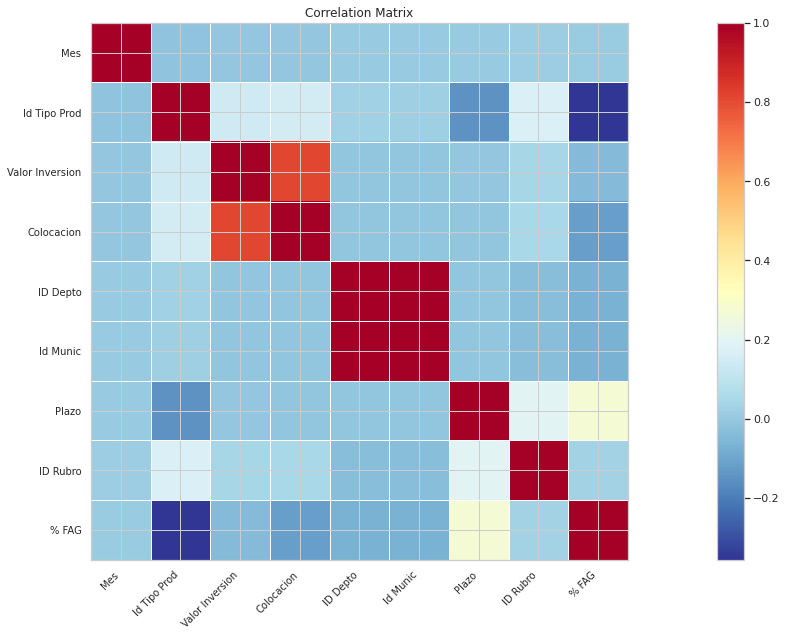

In [ ]:
import statsmodels.api as sm
corr = df_DataSet1.set_index('Linea de Credito').corr() # 
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

In [ ]:
from sklearn.impute import MissingIndicator # Es una función que permite identificar los datos faltantes

In [ ]:
Indicador = MissingIndicator(missing_values = np.nan) # Decimos que datos debe buscar como datos faltantes
Indicador.fit(df_DataSet1) # Aplicamos el método de búsqueda con nuestra base de datos
Datos_Indicador = Indicador.transform(df_DataSet1) # Realizamos una transformación Booleana de los datos para identificar los datos faltantes (True)
                                             # y los datos no faltantes (False)
display(Datos_Indicador)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
print("Características donde hay datos faltantes: ", Indicador.features_)

Características donde hay datos faltantes:  [13 14]


In [ ]:
POS = np.where(Datos_Indicador == True) # Se busca aquellos datos que tiene un valor Booleanos igual a True
print("Porcentaje de Datos Faltantes (%): ", 100*(len(POS[0])/(Datos_Indicador.shape[0]*Datos_Indicador.shape[1])))

Porcentaje de Datos Faltantes (%):  37.258165999274965


In [ ]:
# Se decide eliminar las variables por el porcentaje alto de datos faltantes y por ser considerada una variable de poco interes
df_DataSet1=df_DataSet1.drop(['% FAG', 'Vlr Inic Garantia'], axis=1)

#Preparacion De Variables (Categoricas a Númericas)

In [ ]:
# Estado actual del dataset
df_DataSet1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Mes                         479978 non-null  int64   
 1   fuente Colocacion           479978 non-null  category
 2   Id Tipo Prod                479978 non-null  int64   
 3   Valor Inversion             479978 non-null  float64 
 4   Colocacion                  479978 non-null  float64 
 5   ID Depto                    479978 non-null  int64   
 6   Id Munic                    479978 non-null  int64   
 7   Municipio de PostConflico?  479978 non-null  category
 8   Plazo                       479978 non-null  int64   
 9   Linea de Credito            479978 non-null  category
 10  Linea de Produccion         479978 non-null  category
 11  ID Rubro                    479978 non-null  float64 
 12  Genero                      479978 non-null  category
dtyp

In [ ]:
df_DataSetNum =df_DataSet1.copy() #Hacemos una copia de los datos

from sklearn.preprocessing import LabelEncoder # Codificación de etiquetas
import numpy as np
from collections import defaultdict # Para generar un diccionario nuevo de valores
#from pyspark.ml.feature import StringIndexer

LE = defaultdict(LabelEncoder)

# fuente Colocacion
data_1 = df_DataSetNum.loc[:,['fuente Colocacion']]#.iloc[:, 1:2]
Datos_FC = data_1.apply(lambda x: LE[x.name].fit_transform(x))
df_DataSetNum['fuente Colocacion'] = Datos_FC["fuente Colocacion"]

# Municipio de PostConflico?
data_1 = df_DataSetNum.loc[:,['Municipio de PostConflico?']]#.iloc[:, 7:8]
Datos_MP = data_1.apply(lambda x: LE[x.name].fit_transform(x))
df_DataSetNum['Municipio de PostConflico?'] = Datos_MP["Municipio de PostConflico?"]

# Linea de Produccion
data_1 = df_DataSetNum.loc[:,['Linea de Produccion']]#.iloc[:, 1:2]
Datos_LP = data_1.apply(lambda x: LE[x.name].fit_transform(x))
df_DataSetNum['Linea de Produccion'] = Datos_LP["Linea de Produccion"]

# Genero
data_1 = df_DataSetNum.loc[:,['Genero']]#.iloc[:, 1:2]
Datos_GE = data_1.apply(lambda x: LE[x.name].fit_transform(x))
df_DataSetNum['Genero'] = Datos_GE["Genero"]

display(df_DataSetNum)


,Mes,fuente Colocacion,Id Tipo Prod,Valor Inversion,Colocacion,ID Depto,Id Munic,Municipio de PostConflico?,Plazo,Linea de Credito,Linea de Produccion,ID Rubro,Genero
0,2,1,1,25000000.0,11185899.0,15,15599,0,36,Normalización de Cartera,13,141550.0,1
1,2,1,1,53600000.0,40000000.0,19,19548,0,84,Inversión,6,347050.0,0
2,2,1,1,107759000.0,100000000.0,5,5237,1,60,Inversión,6,347495.0,0
3,2,0,0,2950000.0,2089560.0,76,76233,1,9,Normalización de Cartera,14,160000.0,1
4,2,0,0,7700000.0,6801690.0,13,13670,1,46,Normalización de Cartera,7,447350.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479973,10,2,1,2000000.0,2000000.0,17,17380,0,12,Capital de Trabajo,14,237050.0,0
479974,11,1,0,18000000.0,18000000.0,15,15776,0,36,Capital de Trabajo,14,160000.0,0
479975,11,2,1,2480000.0,2480000.0,66,66440,0,12,Capital de Trabajo,14,132310.0,0
479976,11,2,1,40000000.0,40000000.0,20,20238,1,12,Capital de Trabajo,14,237280.0,0


In [ ]:
#Se codifican las categorias de la variable objetivo
df_DataSetNum["Linea de Credito"]=df_DataSetNum["Linea de Credito"].replace({"Capital de Trabajo": 0, "Inversión": 1, "Normalización de Cartera":2})

df_DataSetNum.head()

,Mes,fuente Colocacion,Id Tipo Prod,Valor Inversion,Colocacion,ID Depto,Id Munic,Municipio de PostConflico?,Plazo,Linea de Credito,Linea de Produccion,ID Rubro,Genero
0,2,1,1,25000000.0,11185899.0,15,15599,0,36,2,13,141550.0,1
1,2,1,1,53600000.0,40000000.0,19,19548,0,84,1,6,347050.0,0
2,2,1,1,107759000.0,100000000.0,5,5237,1,60,1,6,347495.0,0
3,2,0,0,2950000.0,2089560.0,76,76233,1,9,2,14,160000.0,1
4,2,0,0,7700000.0,6801690.0,13,13670,1,46,2,7,447350.0,0


In [ ]:
from sklearn.impute import SimpleImputer  # Método de imputación 
#imp_mean = SimpleImputer(strategy='median') # Rellena los datos NaN con la media
imp_mean = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent') # Rellena los datos NaN por medio del cálculo de los valores más frecuentes
df_DataSetDataImput = imp_mean.fit_transform(df_DataSetNum)

In [ ]:
df_DataSetModelo = pd.DataFrame(df_DataSetDataImput, columns = df_DataSetNum.columns)
df_DataSetModelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Mes                         479978 non-null  float64
 1   fuente Colocacion           479978 non-null  float64
 2   Id Tipo Prod                479978 non-null  float64
 3   Valor Inversion             479978 non-null  float64
 4   Colocacion                  479978 non-null  float64
 5   ID Depto                    479978 non-null  float64
 6   Id Munic                    479978 non-null  float64
 7   Municipio de PostConflico?  479978 non-null  float64
 8   Plazo                       479978 non-null  float64
 9   Linea de Credito            479978 non-null  float64
 10  Linea de Produccion         479978 non-null  float64
 11  ID Rubro                    479978 non-null  float64
 12  Genero                      479978 non-null  float64
dtypes: float64(13)

In [ ]:
df_DataSetModeloCopia = df_DataSetModelo.copy() # Copia backup del dataset con datos imputados

# Graficos Informativos

**Graficos Comparativos** : Se realizan histogramas de las variables cruzandolas directamente con la variable de Linea de Credito

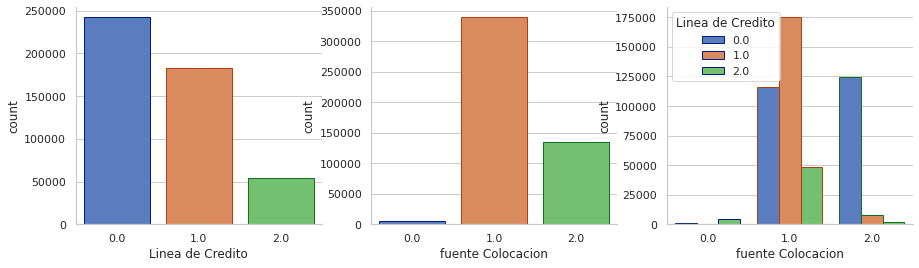

In [ ]:
df_sex= df_DataSetModelo.loc[:,["fuente Colocacion", "Linea de Credito"]]
fig,ax= plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=df_sex['Linea de Credito'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[0])
sns.despine()
sns.countplot(x=df_sex['fuente Colocacion'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[1])
sns.despine()
sns.countplot(data=df_DataSetModelo,x="fuente Colocacion",hue="Linea de Credito",palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[2])
sns.despine()

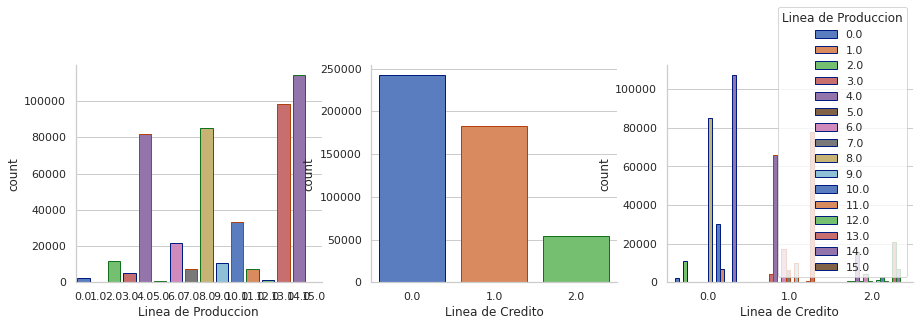

In [ ]:
df_sex= df_DataSetModelo.loc[:,["Linea de Produccion","Linea de Credito"]]
fig,ax= plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=df_sex['Linea de Produccion'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[0])
sns.despine()
sns.countplot(x=df_sex['Linea de Credito'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[1])
sns.despine()
sns.countplot(data=df_DataSetModelo,x="Linea de Credito",hue="Linea de Produccion",palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[2])
sns.despine()

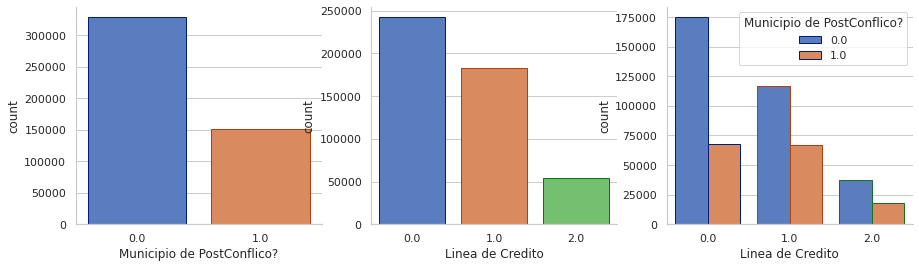

In [ ]:
# Municipio de PostConflico?
df_sex= df_DataSetModelo.loc[:,["Municipio de PostConflico?","Linea de Credito"]]
fig,ax= plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=df_sex['Municipio de PostConflico?'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[0])
sns.despine()
sns.countplot(x=df_sex['Linea de Credito'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[1])
sns.despine()
sns.countplot(data=df_DataSetModelo,x="Linea de Credito",hue="Municipio de PostConflico?",palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[2])
sns.despine()

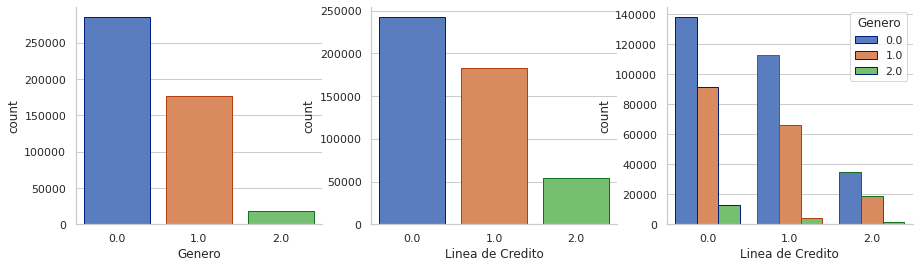

In [ ]:
# Genero
df_sex= df_DataSetModelo.loc[:,["Genero","Linea de Credito"]]
fig,ax= plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=df_sex['Genero'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[0])
sns.despine()
sns.countplot(x=df_sex['Linea de Credito'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[1])
sns.despine()
sns.countplot(data=df_DataSetModelo,x="Linea de Credito",hue="Genero",palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[2])
sns.despine()

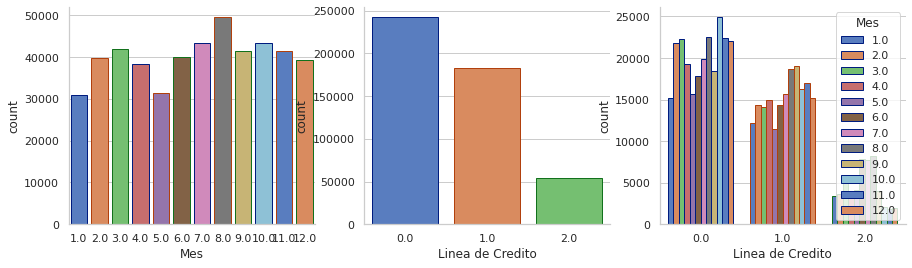

In [ ]:
# Mes
df_sex= df_DataSetModelo.loc[:,["Mes","Linea de Credito"]]
fig,ax= plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=df_sex['Mes'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[0])
sns.despine()
sns.countplot(x=df_sex['Linea de Credito'],palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[1])
sns.despine()
sns.countplot(data=df_DataSetModelo,x="Linea de Credito",hue="Mes",palette=sns.color_palette("muted"),edgecolor=sns.color_palette("dark", 3),ax=ax[2])
sns.despine()

**Graficos Por Variable Categorica**

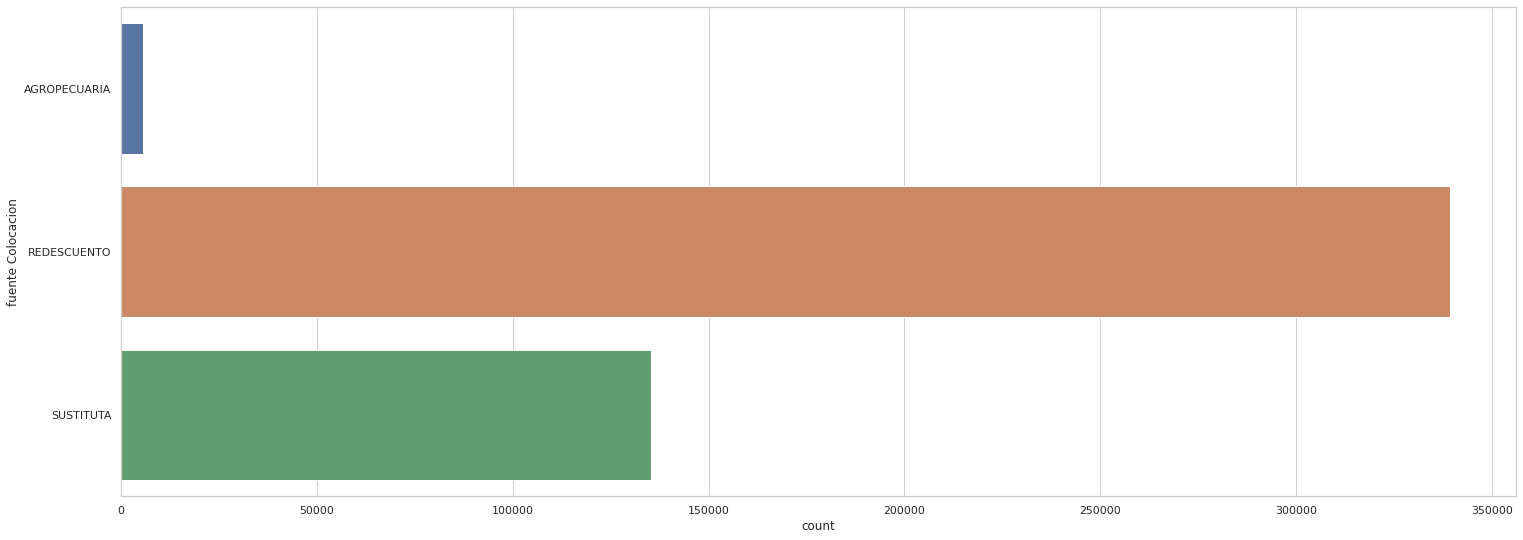

In [ ]:
sns.countplot(y=df_DataSet1['fuente Colocacion'])

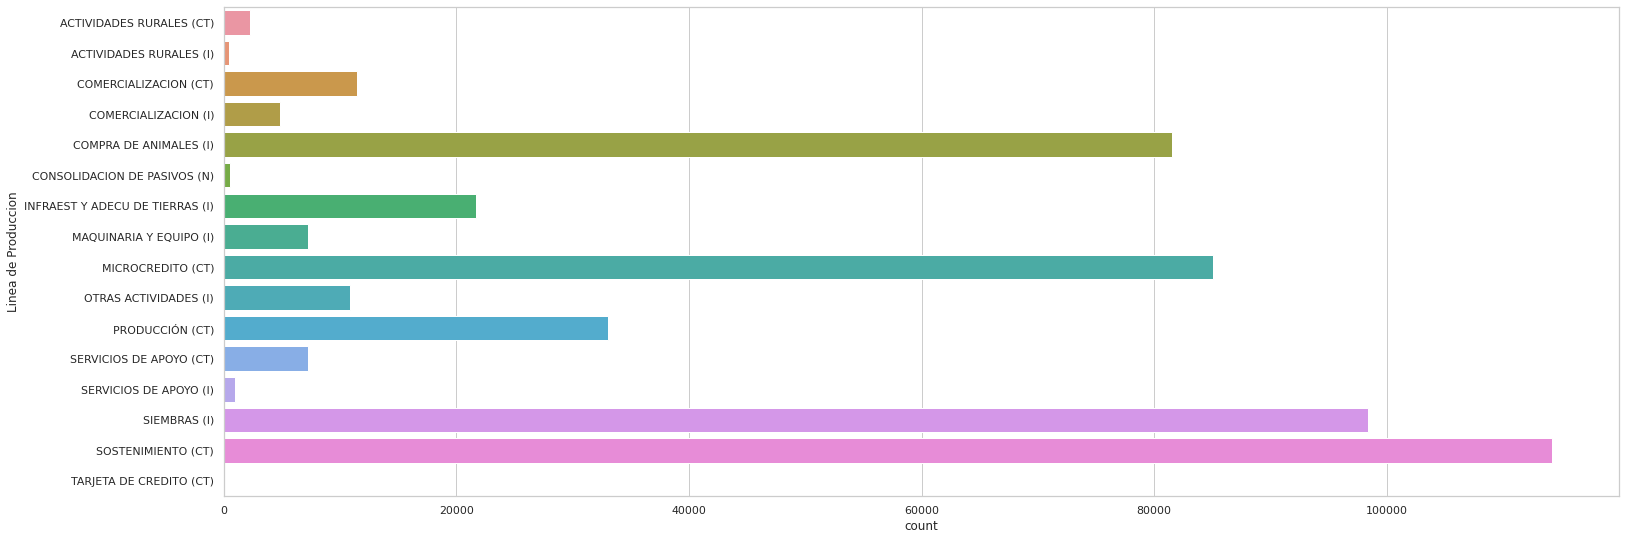

In [ ]:
sns.countplot(y=df_DataSet1['Linea de Produccion'])

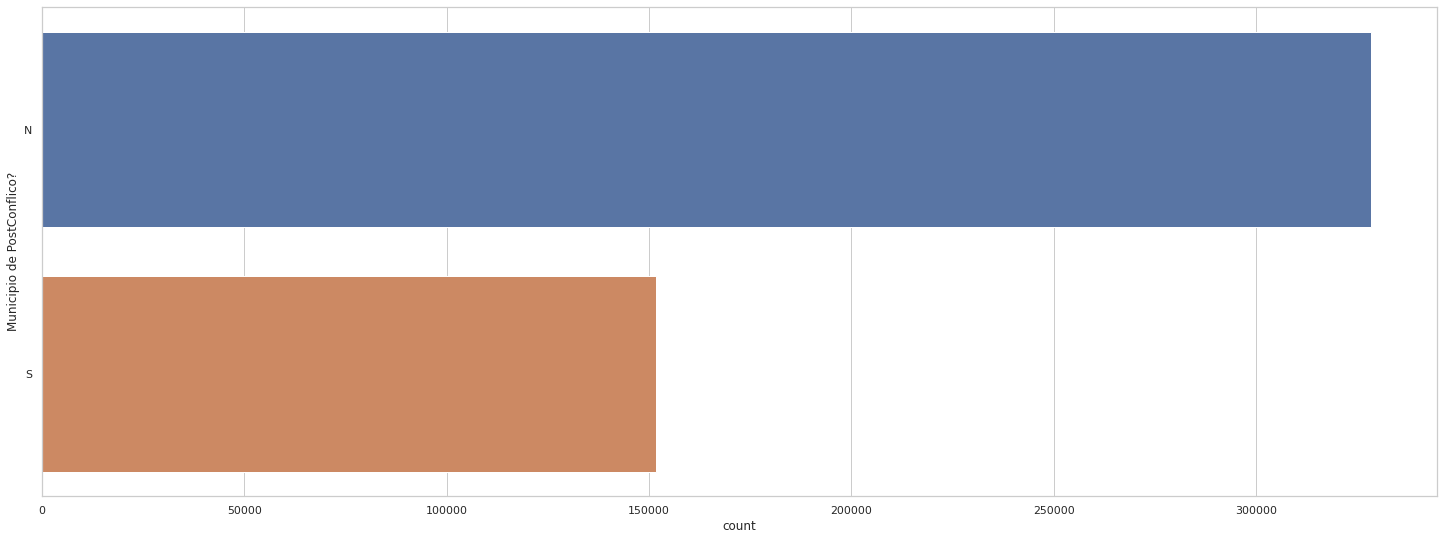

In [ ]:
sns.countplot(y=df_DataSet1['Municipio de PostConflico?'])

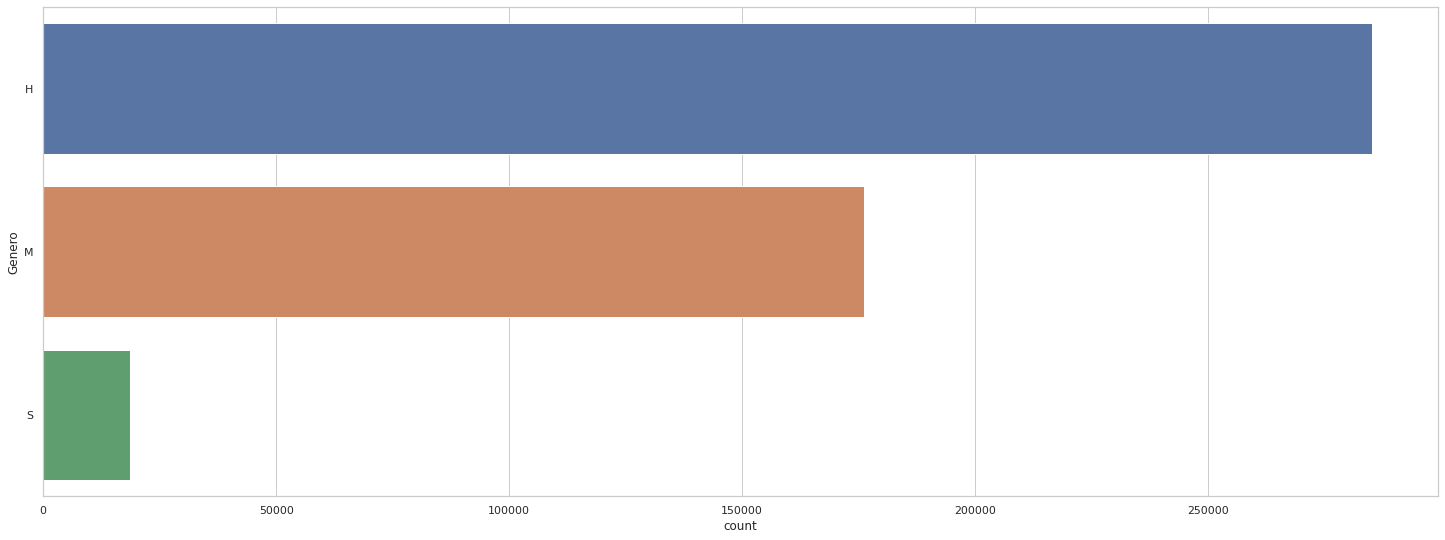

In [ ]:
sns.countplot(y=df_DataSet1['Genero'])

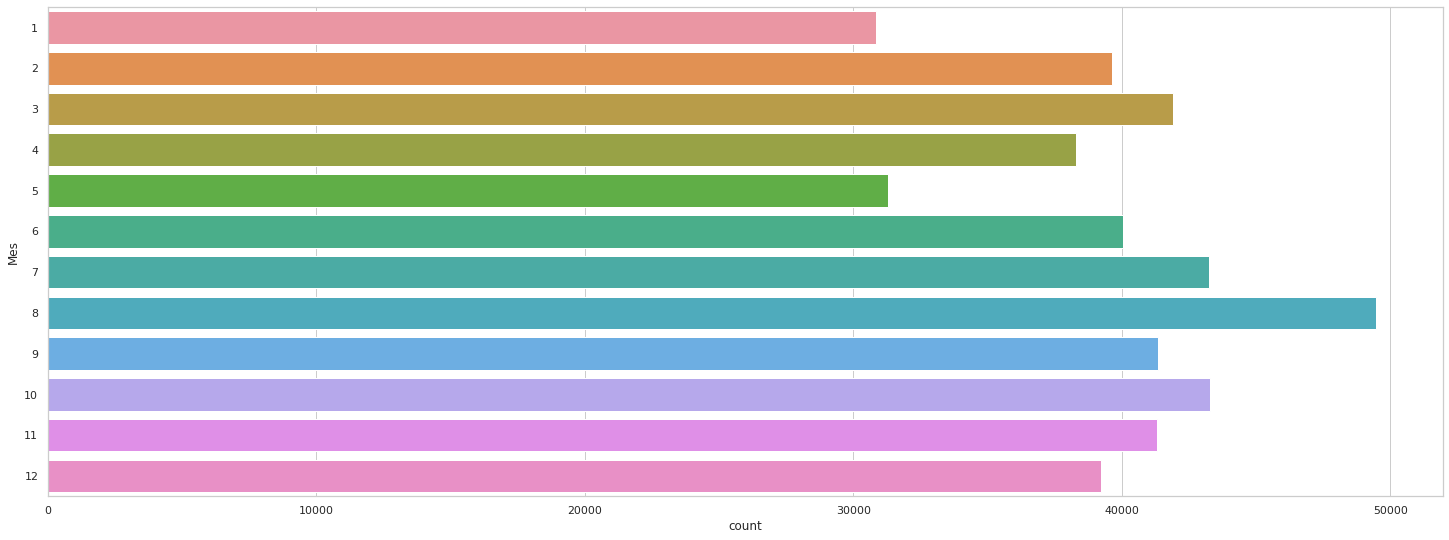

In [ ]:
sns.countplot(y=df_DataSet1['Mes'])

# Analisis Previo a Modelado

In [ ]:
df_DataSetModelo.shape

(479978, 13)

In [ ]:
df_DataSetModelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479978 entries, 0 to 479977
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Mes                         479978 non-null  float64
 1   fuente Colocacion           479978 non-null  float64
 2   Id Tipo Prod                479978 non-null  float64
 3   Valor Inversion             479978 non-null  float64
 4   Colocacion                  479978 non-null  float64
 5   ID Depto                    479978 non-null  float64
 6   Id Munic                    479978 non-null  float64
 7   Municipio de PostConflico?  479978 non-null  float64
 8   Plazo                       479978 non-null  float64
 9   Linea de Credito            479978 non-null  float64
 10  Linea de Produccion         479978 non-null  float64
 11  ID Rubro                    479978 non-null  float64
 12  Genero                      479978 non-null  float64
dtypes: float64(13)

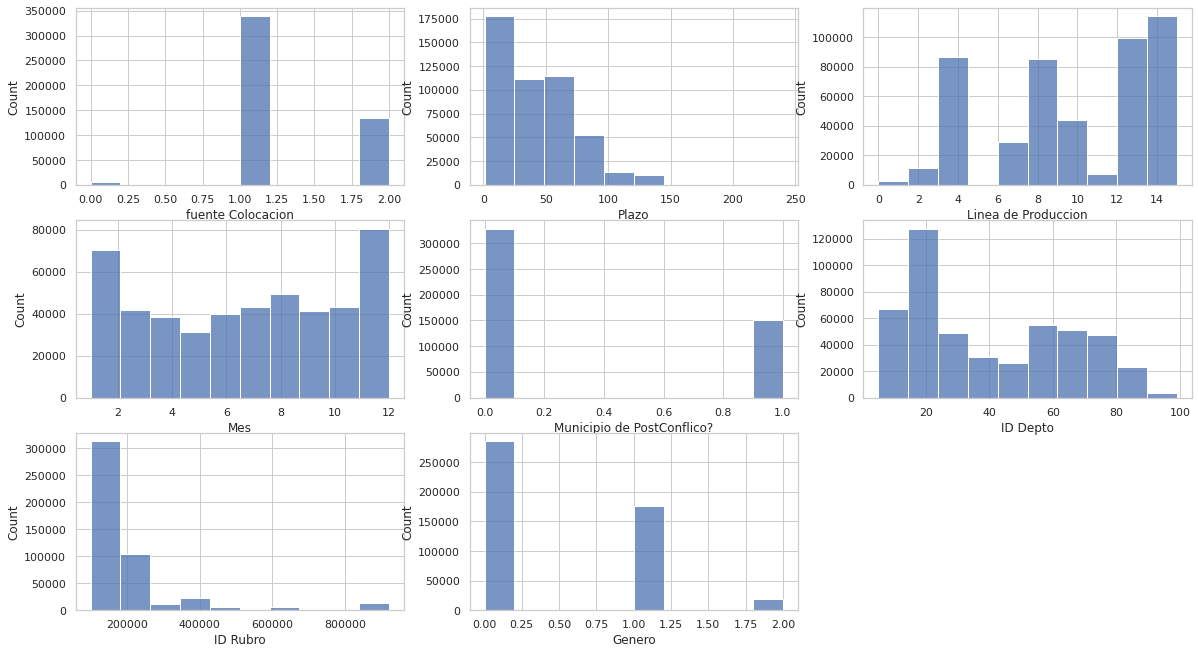

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(4,3,1)
sns.histplot(df_DataSetModelo['fuente Colocacion'],bins=10)
plt.subplot(4,3,2)
sns.histplot(df_DataSetModelo['Plazo'],bins=10)
plt.subplot(4,3,3)
sns.histplot(df_DataSetModelo['Linea de Produccion'],bins=10)
plt.subplot(4,3,4)
sns.histplot(df_DataSetModelo['Mes'],bins=10)
plt.subplot(4,3,5)
sns.histplot(df_DataSetModelo['Municipio de PostConflico?'],bins=10)
plt.subplot(4,3,6)
sns.histplot(df_DataSetModelo['ID Depto'],bins=10)
plt.subplot(4,3,7)
sns.histplot(df_DataSetModelo['ID Rubro'],bins=10)
plt.subplot(4,3,8)
sns.histplot(df_DataSetModelo['Genero'],bins=10)
# 

In [ ]:
df_DataSetModelo.describe()

,Mes,fuente Colocacion,Id Tipo Prod,Valor Inversion,Colocacion,ID Depto,Id Munic,Municipio de PostConflico?,Plazo,Linea de Credito,Linea de Produccion,ID Rubro,Genero
count,479978.000000,479978.000000,479978.000000,4.799780e+05,4.799780e+05,479978.000000,479978.000000,479978.000000,479978.000000,479978.000000,479978.000000,479978.000000,479978.000000
mean,6.697232,1.270054,0.167533,7.414768e+07,5.721430e+07,38.750620,39163.690030,0.316081,44.873746,0.609405,9.639665,217461.194853,0.444950
std,3.380452,0.469620,0.434091,1.683558e+09,1.207879e+09,25.422284,25408.073934,0.464945,31.929417,0.682575,3.981957,142289.668455,0.570024
min,1.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,5.000000,5001.000000,0.000000,1.000000,0.000000,0.000000,101002.000000,0.000000
25%,4.000000,1.000000,0.000000,3.400000e+06,3.180000e+06,17.000000,17042.000000,0.000000,18.000000,0.000000,6.000000,141430.000000,0.000000
50%,7.000000,1.000000,0.000000,9.000000e+06,8.000000e+06,25.000000,25899.000000,0.000000,36.000000,0.000000,10.000000,165000.000000,0.000000
75%,10.000000,2.000000,0.000000,1.500000e+07,1.500000e+07,66.000000,66045.000000,1.000000,60.000000,1.000000,13.000000,253100.000000,1.000000
max,12.000000,2.000000,2.000000,3.511180e+11,3.000000e+11,99.000000,99773.000000,1.000000,240.000000,2.000000,15.000000,920008.000000,2.000000


In [ ]:
df_ModeloV2=sqlCtx.createDataFrame(df_DataSetModelo)
df_ModeloV2.printSchema()
df_ModeloV2.show(5)

root
 |-- Mes: double (nullable = true)
 |-- fuente Colocacion: double (nullable = true)
 |-- Id Tipo Prod: double (nullable = true)
 |-- Valor Inversion: double (nullable = true)
 |-- Colocacion: double (nullable = true)
 |-- ID Depto: double (nullable = true)
 |-- Id Munic: double (nullable = true)
 |-- Municipio de PostConflico?: double (nullable = true)
 |-- Plazo: double (nullable = true)
 |-- Linea de Credito: double (nullable = true)
 |-- Linea de Produccion: double (nullable = true)
 |-- ID Rubro: double (nullable = true)
 |-- Genero: double (nullable = true)

+---+-----------------+------------+---------------+-----------+--------+--------+--------------------------+-----+----------------+-------------------+--------+------+
|Mes|fuente Colocacion|Id Tipo Prod|Valor Inversion| Colocacion|ID Depto|Id Munic|Municipio de PostConflico?|Plazo|Linea de Credito|Linea de Produccion|ID Rubro|Genero|
+---+-----------------+------------+---------------+-----------+--------+--------+-----

In [ ]:
vectorAssembler = VectorAssembler(inputCols = \
    ['Mes', 'fuente Colocacion', 'Id Tipo Prod', 'Valor Inversion', 'Colocacion', 'ID Depto', 'Id Munic', 'Municipio de PostConflico?', 'Plazo', 'Linea de Produccion', 'ID Rubro', 'Genero'], outputCol = 'features')
vest = vectorAssembler.transform(df_ModeloV2)
vest = vest.select(['features', 'Linea de Credito'])
vest.show(5)

+--------------------+----------------+
|            features|Linea de Credito|
+--------------------+----------------+
|[2.0,1.0,1.0,2.5E...|             2.0|
|[2.0,1.0,1.0,5.36...|             1.0|
|[2.0,1.0,1.0,1.07...|             1.0|
|[2.0,0.0,0.0,2950...|             2.0|
|[2.0,0.0,0.0,7700...|             2.0|
+--------------------+----------------+
only showing top 5 rows



In [ ]:
(trainingData, testData) = vest.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

336268
143710


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import seaborn as sn
import matplotlib.pyplot as plt

# Modelo 1: Regresión Logística

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Linea de Credito", featuresCol="features",maxIter=10)
lr_model=lr.fit(trainingData)

In [ ]:
trainingSummary = lr_model.summary
trainingSummary.predictions.select('Linea de Credito','prediction','probability').show(5)

+----------------+----------+--------------------+
|Linea de Credito|prediction|         probability|
+----------------+----------+--------------------+
|             2.0|       2.0|[0.28735745514429...|
|             2.0|       0.0|[0.60102193467237...|
|             2.0|       0.0|[0.64194528128714...|
|             2.0|       0.0|[0.48717951896455...|
|             2.0|       2.0|[0.17658982005679...|
+----------------+----------+--------------------+
only showing top 5 rows



In [ ]:
print("Coeficientes: ", str(lr_model.coefficientMatrix))
print("Intercepto: " + str(lr_model.interceptVector))
df_ModeloV2.columns

Coeficientes:  DenseMatrix([[ 2.35045664e-02,  1.50846422e+00, -5.45267004e-01,
              -2.14809978e-11, -1.78113047e-11, -2.82281251e-05,
              -1.29155290e-07, -1.76269394e-01, -6.39351854e-02,
               9.21098595e-02, -6.67777855e-07,  7.28080742e-02],
             [-1.46991310e-02, -8.87250596e-01,  3.79113641e-01,
              -1.16455682e-11,  4.36347510e-12, -2.16226611e-03,
              -2.40208492e-06, -4.88028748e-03,  6.09722541e-02,
              -1.20755253e-01, -6.75648119e-07, -8.57412235e-03],
             [-8.80543538e-03, -6.21213623e-01,  1.66153363e-01,
               3.31265660e-11,  1.34478296e-11,  2.19049424e-03,
               2.53124021e-06,  1.81149682e-01,  2.96293134e-03,
               2.86453934e-02,  1.34342597e-06, -6.42339518e-02]])
Intercepto: [0.5264261921166788,-0.009337241633689939,-0.5170889504829889]


['Mes',
 'fuente Colocacion',
 'Id Tipo Prod',
 'Valor Inversion',
 'Colocacion',
 'ID Depto',
 'Id Munic',
 'Municipio de PostConflico?',
 'Plazo',
 'Linea de Credito',
 'Linea de Produccion',
 'ID Rubro',
 'Genero']

In [ ]:
print('Accuracy: ' + str(trainingSummary.accuracy))

Accuracy: 0.8498459562016011


Evaluar

In [ ]:
predict_testRL=lr_model.transform(testData)
predict_testRL.select('Linea de Credito','prediction','probability').show(10)

+----------------+----------+--------------------+
|Linea de Credito|prediction|         probability|
+----------------+----------+--------------------+
|             2.0|       0.0|[0.50129849310800...|
|             2.0|       2.0|[0.28776899892488...|
|             2.0|       1.0|[0.04565082018276...|
|             2.0|       0.0|[0.64764946018309...|
|             2.0|       1.0|[0.04708671692367...|
|             2.0|       1.0|[0.07409477692230...|
|             2.0|       1.0|[0.01203779239303...|
|             2.0|       2.0|[0.34395108707989...|
|             2.0|       1.0|[0.05365785326851...|
|             2.0|       1.0|[0.07655659877891...|
+----------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='Linea de Credito')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_testRL))

Área ROC con los datos de evaluación 0.953333745674395


In [ ]:
clase_real_RL = predict_testRL.select(['Linea de Credito']).collect()
clase_prediccion_RL = predict_testRL.select(['prediction']).collect()

print("Medidas de error")
print(classification_report(clase_real_RL, clase_prediccion_RL))

Medidas de error
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91     72413
         1.0       0.84      0.94      0.89     55010
         2.0       0.39      0.03      0.06     16287

    accuracy                           0.85    143710
   macro avg       0.70      0.65      0.62    143710
weighted avg       0.80      0.85      0.81    143710



Matriz de confusión RL
[[0.96548962 0.02677696 0.00773342]
 [0.05300854 0.94130158 0.00568987]
 [0.48081292 0.48425124 0.03493584]]


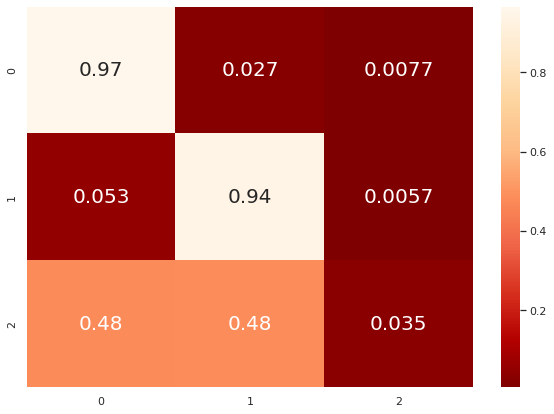

In [ ]:
print("Matriz de confusión RL")
cmatrix_RL = confusion_matrix(clase_real_RL, clase_prediccion_RL, normalize='true')
print(cmatrix_RL)
df_cmRL = pd.DataFrame(cmatrix_RL, range(3), range(3))
plt.figure(figsize = (10,7))
sn.heatmap(df_cmRL, annot=True, annot_kws={"size": 20},cmap="OrRd_r")

plt.show()


# Modelo 2: Árboles de decisión para clasificación

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Linea de Credito", featuresCol="features")
dt_model=dt.fit(trainingData)

In [ ]:
predict_trainAD = dt_model.transform(trainingData)
predict_trainAD.select('Linea de Credito','prediction').show(5)

+----------------+----------+
|Linea de Credito|prediction|
+----------------+----------+
|             2.0|       2.0|
|             2.0|       0.0|
|             2.0|       0.0|
|             2.0|       2.0|
|             2.0|       2.0|
+----------------+----------+
only showing top 5 rows



Evaluar

In [ ]:
predict_testAD = dt_model.transform(testData)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='Linea de Credito')
print('Área ROC con los datos de evaluación', evaluator.evaluate(predict_testAD))

Área ROC con los datos de evaluación 0.9688460174824275


In [ ]:
clase_realAD = predict_testAD.select(['Linea de Credito']).collect()
clase_prediccionAD = predict_testAD.select(['prediction']).collect()

print("Medidas de error")
print(classification_report(clase_realAD, clase_prediccionAD))

Medidas de error
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     72413
         1.0       0.92      0.97      0.95     55010
         2.0       0.86      0.55      0.67     16287

    accuracy                           0.94    143710
   macro avg       0.91      0.84      0.87    143710
weighted avg       0.94      0.94      0.93    143710



Matriz de confusión AD
[[9.99544281e-01 2.76193501e-04 1.79525776e-04]
 [4.18105799e-04 9.72768588e-01 2.68133067e-02]
 [1.78731504e-01 2.68803340e-01 5.52465156e-01]]


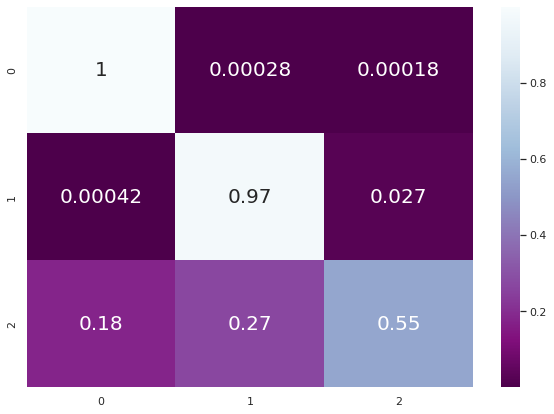

In [ ]:
print("Matriz de confusión AD")
cmatrix_AD = confusion_matrix(clase_realAD, clase_prediccionAD, normalize='true')
print(cmatrix_AD)
df_cmAD = pd.DataFrame(cmatrix_AD, range(3), range(3))
plt.figure(figsize = (10,7))
sn.heatmap(df_cmAD, annot=True, annot_kws={"size": 20},cmap="BuPu_r")

plt.show()

# Modelo 3: KNeighborsClassifier

In [ ]:
Xkc = df_DataSetModelo[['Mes', 'fuente Colocacion', 'Id Tipo Prod', 'Valor Inversion', 'Colocacion', 'ID Depto', 'Id Munic', 'Municipio de PostConflico?', 'Plazo', 'Linea de Produccion', 'ID Rubro', 'Genero']].values
ykc = df_DataSetModelo['Linea de Credito'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_trainKC, X_testKC, y_trainKC, y_testKC = train_test_split(Xkc, ykc, random_state=0)
scaler = MinMaxScaler()
X_trainKC = scaler.fit_transform(X_trainKC)
X_testKC = scaler.transform(X_testKC)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_trainKC, y_trainKC)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_trainKC, y_trainKC)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_testKC, y_testKC)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.93


Evaluar

In [ ]:
predKNN = knn.predict(X_testKC)


In [ ]:
print("Medidas de error")
print(classification_report(y_testKC, predKNN))

Medidas de error
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     60865
         1.0       0.91      0.97      0.94     45548
         2.0       0.83      0.53      0.65     13582

    accuracy                           0.93    119995
   macro avg       0.90      0.83      0.85    119995
weighted avg       0.93      0.93      0.92    119995



Matriz de confusión KNeighborsClassifier
[[0.99263945 0.00139653 0.00596402]
 [0.00878194 0.96673839 0.02447967]
 [0.14548667 0.3237373  0.53077603]]


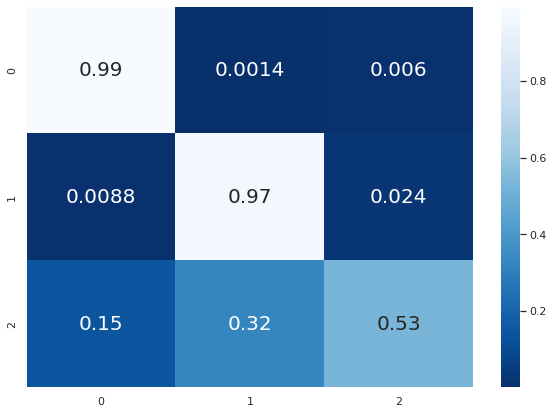

In [ ]:
print("Matriz de confusión KNeighborsClassifier")
cmatrix_KC = confusion_matrix(y_testKC, predKNN, normalize='true')
print(cmatrix_KC)
df_cmKC = pd.DataFrame(cmatrix_KC, range(3), range(3))
plt.figure(figsize = (10,7))
sn.heatmap(df_cmKC, annot=True, annot_kws={"size": 20},cmap="Blues_r")

plt.show()

# Modelo 4: Kmeans

In [ ]:
from pyspark.ml.clustering import KMeans
km = KMeans( featuresCol='features', k=3, predictionCol='cluster', distanceMeasure='euclidean')
km_model = km.fit(trainingData)

In [ ]:
predictionsKM = km_model.transform(trainingData)
predictionsKM.distinct().show()

+--------------------+----------------+-------+
|            features|Linea de Credito|cluster|
+--------------------+----------------+-------+
|[1.0,1.0,0.0,1750...|             0.0|      0|
|[1.0,1.0,0.0,1850...|             0.0|      0|
|[1.0,1.0,0.0,1900...|             2.0|      0|
|[1.0,1.0,0.0,2000...|             0.0|      0|
|[1.0,1.0,0.0,2400...|             0.0|      0|
|[1.0,1.0,0.0,2580...|             0.0|      0|
|[1.0,1.0,0.0,3000...|             0.0|      0|
|[1.0,1.0,0.0,3000...|             0.0|      0|
|[1.0,1.0,0.0,3200...|             0.0|      0|
|[1.0,1.0,0.0,3210...|             0.0|      0|
|[1.0,1.0,0.0,3460...|             0.0|      0|
|[1.0,1.0,0.0,5000...|             0.0|      0|
|[1.0,1.0,0.0,5190...|             0.0|      0|
|[1.0,1.0,0.0,6000...|             2.0|      0|
|[1.0,1.0,0.0,6000...|             0.0|      0|
|[1.0,1.0,0.0,6000...|             1.0|      0|
|[1.0,1.0,0.0,6000...|             1.0|      0|
|[1.0,1.0,0.0,6000...|             0.0| 

In [ ]:
centers = km_model.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
df_ModeloV2.columns

Centroides: 
[7.0, 1.0, 0.0, 53410836.0, 43344632.0, 39.0, 39200.0, 0.0, 45.0, 10.0, 217296.0, 0.0]
[5.0, 2.0, 2.0, 289633495126.0, 240985265114.0, 40.0, 40501.0, 0.0, 48.0, 6.0, 419131.0, 2.0]
[6.0, 2.0, 2.0, 66604290137.0, 45144625811.0, 31.0, 31626.0, 0.0, 42.0, 7.0, 420811.0, 2.0]
Variables


['Mes',
 'fuente Colocacion',
 'Id Tipo Prod',
 'Valor Inversion',
 'Colocacion',
 'ID Depto',
 'Id Munic',
 'Municipio de PostConflico?',
 'Plazo',
 'Linea de Credito',
 'Linea de Produccion',
 'ID Rubro',
 'Genero']

Evaluar

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(predictionsKM)
print("Índice de la silueta = " + str(silhouette))

Índice de la silueta = 0.9996721219039623


In [ ]:
clase_realKM = predictionsKM.select(['Linea de Credito']).collect()
clase_prediccionKM = predictionsKM.select(['cluster']).collect()

print("Medidas de error")
print(classification_report(clase_realKM, clase_prediccionKM))

Medidas de error
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    169752
         1.0       0.00      0.00      0.00    128115
         2.0       0.53      0.00      0.00     38401

    accuracy                           0.50    336268
   macro avg       0.34      0.33      0.22    336268
weighted avg       0.32      0.50      0.34    336268



Matriz de confusión KMeans
[[9.99823272e-01 0.00000000e+00 1.76728404e-04]
 [9.99929751e-01 0.00000000e+00 7.02493853e-05]
 [9.98802115e-01 5.20819770e-05 1.14580349e-03]]


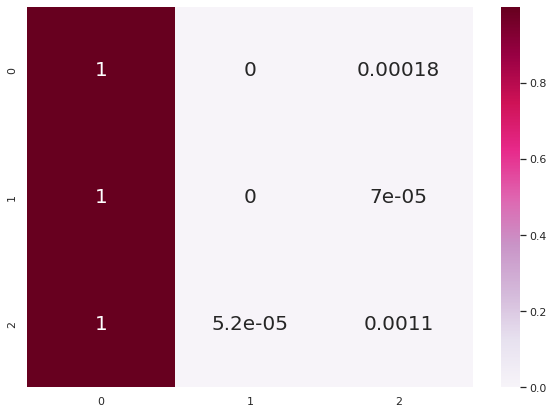

In [ ]:
print("Matriz de confusión KMeans")
cmatrix_KM = confusion_matrix(clase_realKM, clase_prediccionKM, normalize='true')
print(cmatrix_KM)
df_cmKM = pd.DataFrame(cmatrix_KM, range(3), range(3))
plt.figure(figsize = (10,7))
sn.heatmap(df_cmKM, annot=True, annot_kws={"size": 20},cmap="PuRd")

plt.show()

# Resultados

In [ ]:
Accu_LR = accuracy_score(clase_real_RL, clase_prediccion_RL)
BAccu_LR = balanced_accuracy_score(clase_real_RL, clase_prediccion_RL)
print('Modelo1. Regresión Logistica: ')
print('Accuracy = '+str(Accu_LR))
print('Balanced Accuracy = '+str(BAccu_LR))

Modelo1. Regresión Logistica: 
Accuracy = 0.8507689096096305
Balanced Accuracy = 0.6472423473195158


In [ ]:
Accu_AD = accuracy_score(clase_realAD, clase_prediccionAD)
BAccu_AD = balanced_accuracy_score(clase_realAD, clase_prediccionAD)
print('Modelo2. Arboles de decisión para Clasificacion:')
print('Accuracy = '+str(Accu_AD))
print('Balanced Accuracy = '+str(BAccu_AD))

Modelo2. Arboles de decisión para Clasificacion:
Accuracy = 0.9386264003896736
Balanced Accuracy = 0.8415926748374027


In [ ]:
Accu_KNN = accuracy_score(y_testKC, predKNN)
BAccu_KNN = balanced_accuracy_score(y_testKC, predKNN)
print('Modelo3. KNeighborsClassifier:')
print('Accuracy = '+str(Accu_KNN))
print('Balanced Accuracy = '+str(BAccu_KNN))

Modelo3. KNeighborsClassifier:
Accuracy = 0.930530438768282
Balanced Accuracy = 0.8300512869773048


In [ ]:
Accu_Kmeans = accuracy_score(clase_realKM, clase_prediccionKM)
BAccu_Kmeans = balanced_accuracy_score(clase_realKM, clase_prediccionKM)
print('Modelo4. Kmeans:')
print('Accuracy = '+str(Accu_Kmeans))
print('Balanced Accuracy = '+str(BAccu_Kmeans))

Modelo4. Kmeans:
Accuracy = 0.5048532717951159
Balanced Accuracy = 0.3336563583636372


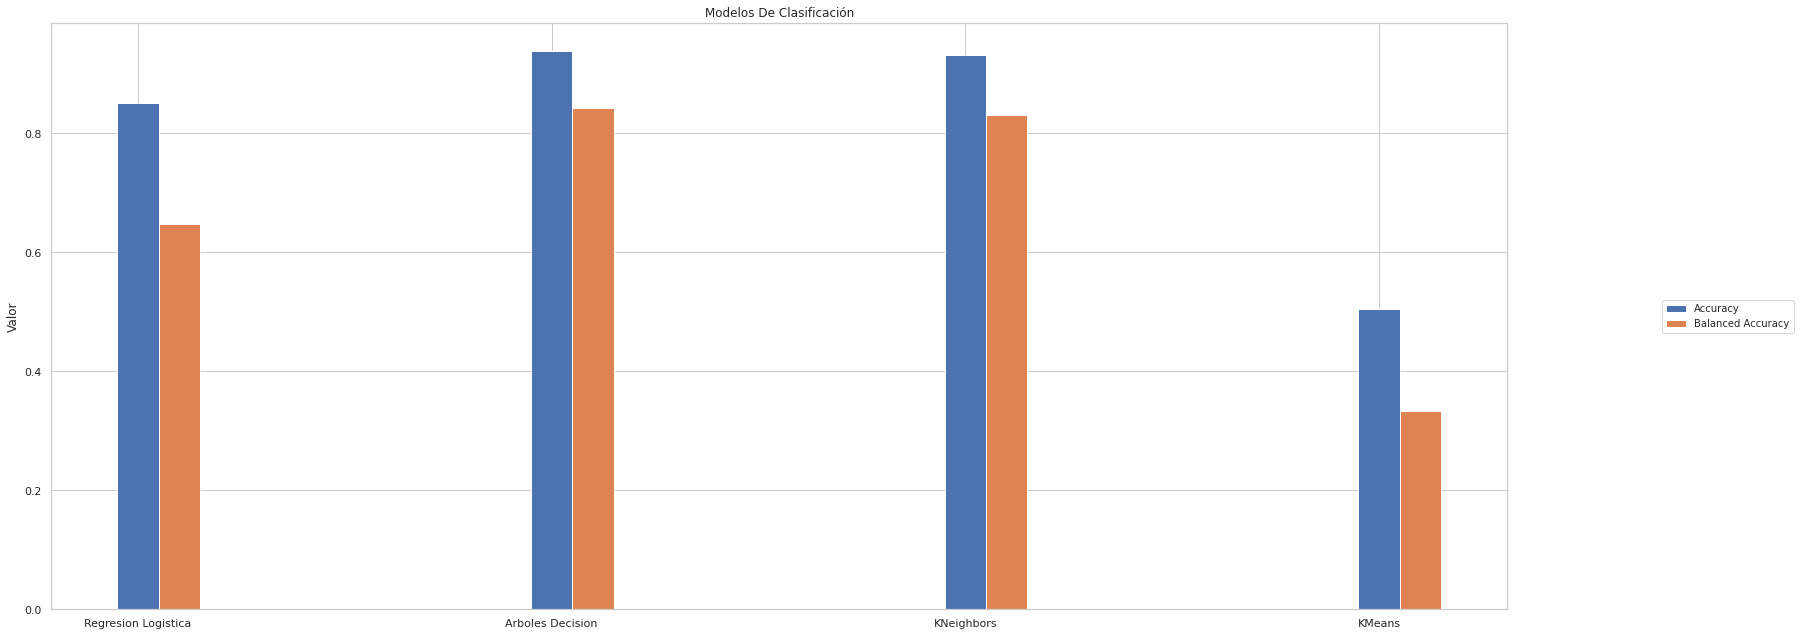

In [ ]:
labels=['Regresion Logistica','Arboles Decision','KNeighbors','KMeans']
measures = ['Accuracy', 'Balanced Accuracy']
Vector = []
Vector.append([Accu_LR, Accu_AD, Accu_KNN, Accu_Kmeans])
Vector.append([BAccu_LR, BAccu_AD, BAccu_KNN, BAccu_Kmeans])

x = np.arange(len(labels))*2
width = 0.2

fig, ax = plt.subplots()
for i in range(len(measures)):
  ax.bar(x+i*width, Vector[i], width, label=measures[i])

ax.set_ylabel('Valor')
ax.set_title('Modelos De Clasificación')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=1, loc='center right', fontsize='small', bbox_to_anchor=(1.2, 0.5))
fig.tight_layout()
plt.show()

# Conclusiones


*   La implementación de varios modelos de clasificación, permitió validar que a pesar de tener una única fuente de datos, las variaciones de parámetros y cálculos arrojan resultados con diferencias visibles, lo cual involucra al personal con conocimientos del negocio a interactuar con dichos resultados y partiendo de un análisis detallado poder tomar decisiones.
*   Los modelos de clasificación que tuvieron un mejor comportamiento, acorde al valor de accuracy, balanced accuracy y matriz de confusión, fueron los algoritmos correspondientes a árboles de decisión y KNeighbors.
* Las métricas empleadas durante el proyecto fueron de gran utilidad, ya que facilitaron la evaluación, interpretación y comparación de los resultados entre los diferentes modelos implementados.

